# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.


In [1]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

/Users/tsing/Study/bioinformatics/DS595/assignment-1-gescobar-tsing/.venv/lib/python3.13/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


---

## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:

-   The high-probability region is thin and curved
-   Random walk proposals often step off the ridge
-   Samplers need to follow the curved geometry efficiently


In [2]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

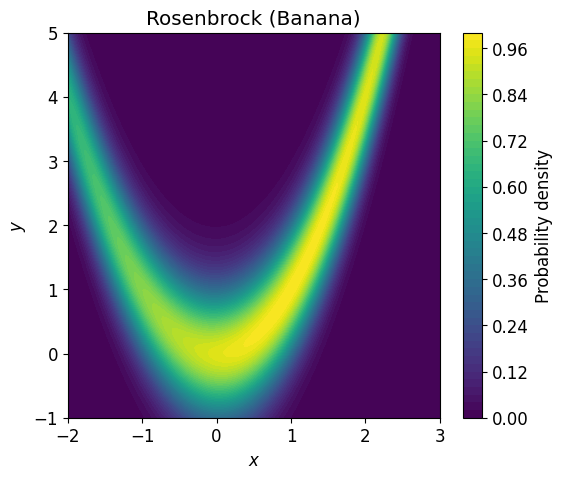

In [3]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---

## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.


In [14]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    # rmh -> random metroplis-hastings
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---

## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.


In [15]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    # hmc -> hamiltonian monte carlo
    hmc = blackjax.hmc(
        log_prob_fn, # pretens it is a phyical valley, BlackJAX automatically uses jax.grad under the hood to know which way is downhill.
        step_size=step_size, # how much time passes in one 'tick' of the simulation
        inverse_mass_matrix=inverse_mass_matrix, # tells sampler that marble has a mass of 1 in every direction
        num_integration_steps=n_leapfrog, # how many 'ticks' to run before stopping to take a sample, i.e. amount of times computer did physics updatees under the hood
    )
    """
        leapfrog algorithm:
            1. update velocity by half-step
            2. update position by full-step using velocity
            3. update velocity by another half-step

    """
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state) # To get 1,000 different random jumps, you need 1,000 different entropy sources (keys).
        # hmc.step -> geenerates random momentum, runs leapfrog simulation, metroplois-hastings check at the end of to correct any simulation errors
        return state, (state.position, info.acceptance_rate, info.is_divergent)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted, divergences) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean(), divergences

---

## Run Baselines on Rosenbrock


In [75]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc, hmc_divergence = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")
num_div = jnp.sum(hmc_divergence) # divergence is a failure of the physics engine
print(f"Total Divergences: {num_div} ({num_div/n_samples*100:.2f}%)")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 74.78%
Total Divergences: 5198 (10.40%)


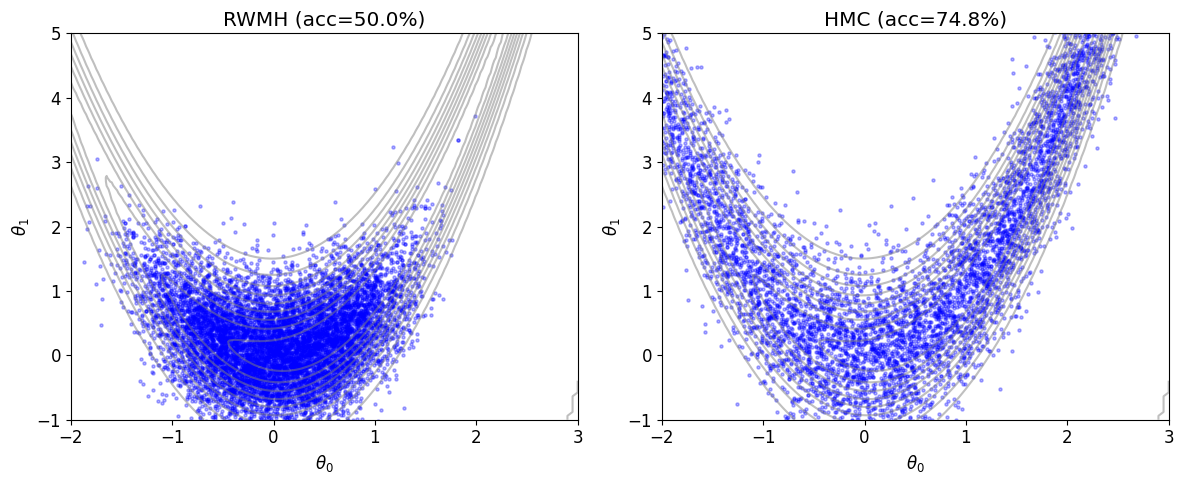

In [76]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---

## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:

-   **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
-   **Effective Sample Size (ESS)**: How many independent samples you effectively have
-   **Trace plots**: Visual check for mixing and stationarity
-   **Autocorrelation**: How correlated successive samples are


In [21]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata, kind="stats"))

In [22]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)


=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.456,2.202,-3.390,4.018
y,4.970,5.012,-0.379,15.324


RWMH Trace Plots:


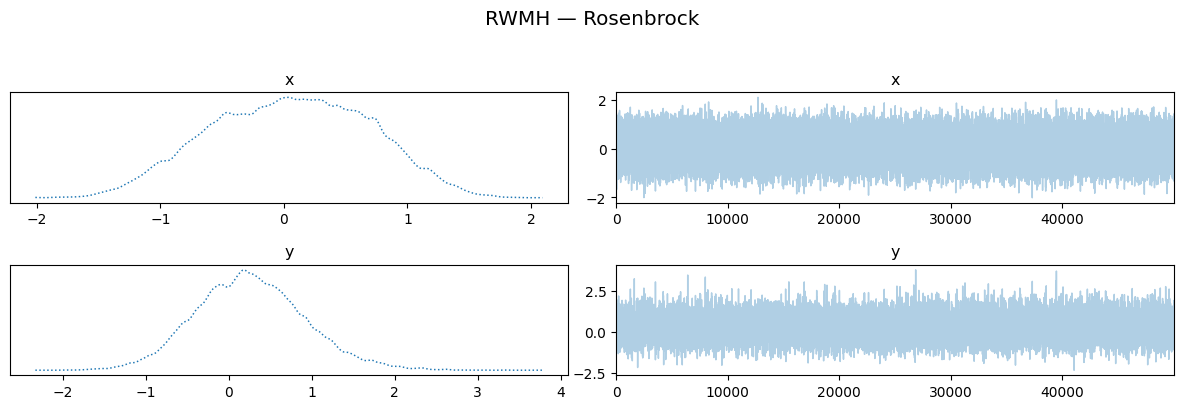


HMC Trace Plots:


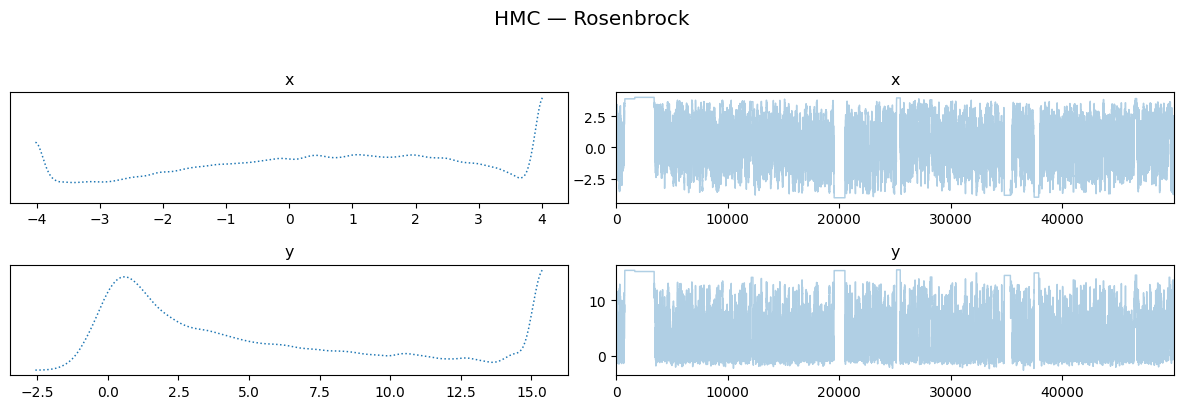

In [23]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

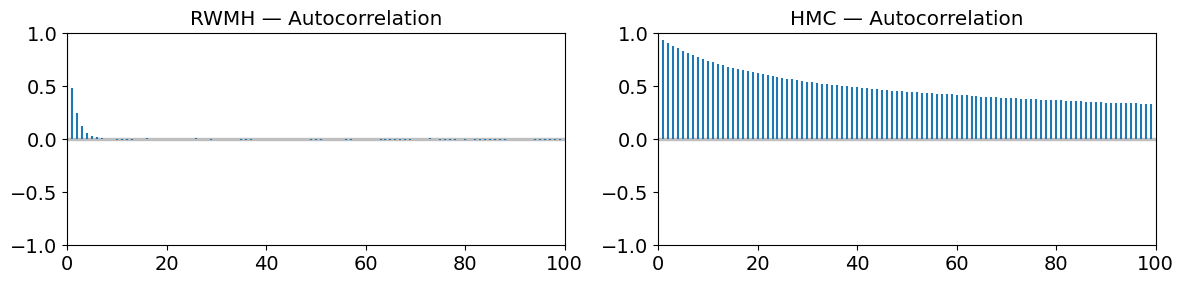

In [24]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---

## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has _lower_ autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:

-   If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
-   If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly _within_ its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.


---

## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:

-   When $v$ is large and positive, $x$ can vary widely
-   When $v$ is large and negative, $x$ is tightly constrained near 0
-   A single step size can't work well everywhere


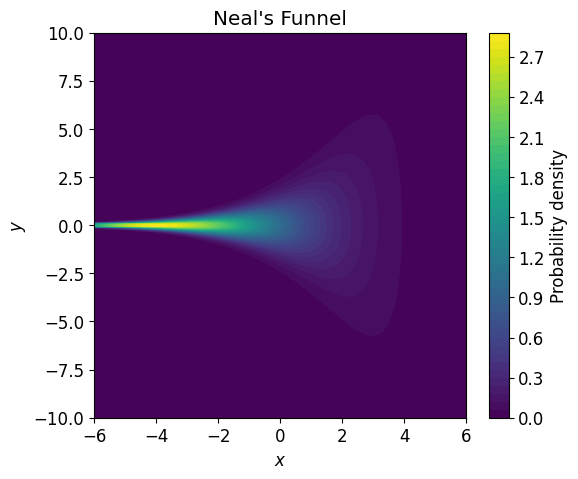

In [25]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

RWMH acceptance rate: 75.66%
HMC acceptance rate: 74.78%
HMC Total Divergences: 5198 (10.40%)


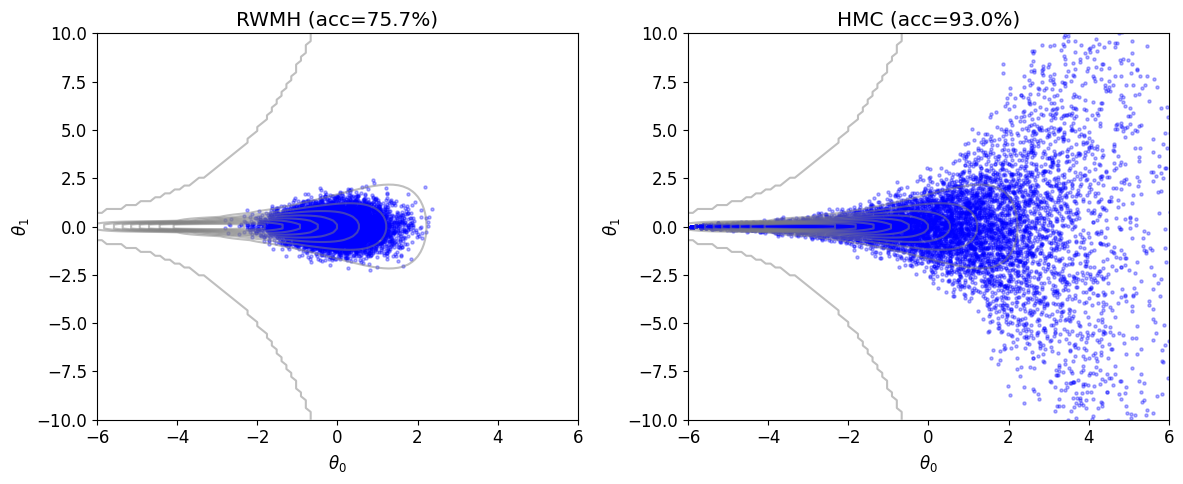

In [205]:
# TODO: Run the RWMH and HMC baselines on Neal's Funnel
# Use the same workflow as Rosenbrock above — you'll need to tune hyperparameters!
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
# if rate > 50% sigma is likely too small
# if rate < 15% sigma is likely too large
rwmh_neals_samples, rwmh_acc = run_rwmh(key1, log_prob_funnel, initial_pos, sigma=0.75, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_neals_samples, hmc_neals_acc, hmc_neals_divergence = run_hmc(
    key2, log_prob_funnel, initial_pos, step_size=0.15, n_leapfrog=20, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")
num_div = jnp.sum(hmc_divergence) # divergence is a failure of the physics engine
print(f"HMC Total Divergences: {num_div} ({num_div/n_samples*100:.2f}%)")

# plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))
plot_samples_comparison(
    rwmh_neals_samples,
    hmc_neals_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_neals_acc:.1%})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)

---

## Your Novel Sampler

Now it's your turn! Implement your own sampler below. Some ideas:

-   **Adaptive proposals**: Adjust step size based on acceptance rate or local curvature
-   **Hybrid methods**: Combine different move types (e.g., local + global moves)
-   **Modified dynamics**: Change the Hamiltonian, use different integrators, add friction
-   **Tempering**: Use temperature schedules to help exploration

A simple idea with thorough analysis beats a complex idea you don't understand!


In [252]:
def novel_adaptive_hmc_sampler(key, log_prob_fn, initial_position, n_samples, target_acc=0.75):
    # Ensure initial_position is a JAX array
    initial_position = jnp.asarray(initial_position)
    
    # Initial parameters
    step_size = 0.1
    n_leapfrog = 50

    # Fixed averaging parameters
    target_log_step = jnp.log(10 * step_size) 
    adaptation_speed = 0.05 
    delay = 10.0             # Use float
    forgetting_rate = 0.75  
    
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])

    def step_fn(state, key):
        # Unpack state
        pos, current_eps, running_avg_err, learned_log_eps, step_count, total_div = state

        # Create and run HMC kernel
        hmc_kernel = blackjax.hmc(
            log_prob_fn, 
            step_size=current_eps, 
            inverse_mass_matrix=inverse_mass_matrix,
            num_integration_steps=n_leapfrog
        )
        
        current_hmc_state = hmc_kernel.init(pos)
        new_hmc_state, info = hmc_kernel.step(key, current_hmc_state)

        # Adaptation Logic
        alpha = info.acceptance_rate
        new_step_count = step_count + 1.0
        weight = 1.0 / (new_step_count + delay)

        # Update running_avg_err (h_bar)
        new_running_avg_err = (1.0 - weight) * running_avg_err + weight * (target_acc - alpha)

        # Calculate the new log_eps for the NEXT step
        log_eps = target_log_step - (jnp.sqrt(new_step_count) / adaptation_speed) * new_running_avg_err
        
        # Update the polished version (log_epsilon_bar)
        learning_rate = new_step_count**-forgetting_rate
        new_learned_log_eps = learning_rate * log_eps + (1.0 - learning_rate) * learned_log_eps
        
        # Determine the epsilon to actually use for the next jump
        next_step_size = jnp.exp(log_eps)
        
        # Cast divergence to float to maintain state consistency
        is_div = info.is_divergent.astype(jnp.float32)
        
        # RETURN: must match the EXACT structure of 'initial_state_tuple'
        new_state_tuple = (new_hmc_state.position, next_step_size, new_running_avg_err, new_learned_log_eps, new_step_count, total_div + is_div)
        output_data = (new_hmc_state.position, info.acceptance_rate, is_div)
        
        return new_state_tuple, output_data

    keys = jr.split(key, n_samples)
    
    # CRITICAL: Initialize everything as floats (0.0) to avoid JAX type-mismatch crashes
    initial_state_tuple = (
        initial_position,        # pos
        step_size,               # current_eps
        0.0,                     # running_avg_err
        jnp.log(step_size),      # learned_log_eps (starting point)
        0.0,                     # step_count
        0.0                      # total_div
    )
    
    # Run the scan
    final_state, (samples, acc_rates, divergences) = jax.lax.scan(step_fn, initial_state_tuple, keys)

    # final_carry[5] is the total_div
    print(acc_rates.mean())
    return samples, acc_rates.mean(), final_state[5]

In [253]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
novel_rosenbrock_samples, novel_rosenbrock_acc, novel_rosenbrock_acc_divergence  = \
    novel_adaptive_hmc_sampler(key1, log_prob_rosenbrock, initial_pos, n_samples=50_000, target_acc=.85)

0.8494931


In [254]:
# TODO: Test your sampler on Neals Funnel
novel_neals_funnel_samples, novel_neals_funnel_acc, novel_neals_funnel_divergence = \
    novel_adaptive_hmc_sampler(key2, log_prob_funnel, initial_pos, n_samples=50_000, target_acc=0.80)

0.79963106



=== Vanilla HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.456,2.202,-3.390,4.018
y,4.970,5.012,-0.379,15.324



=== Novel HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,1.073,3.007,-4.148,7.302
y,10.181,19.127,-1.915,42.028


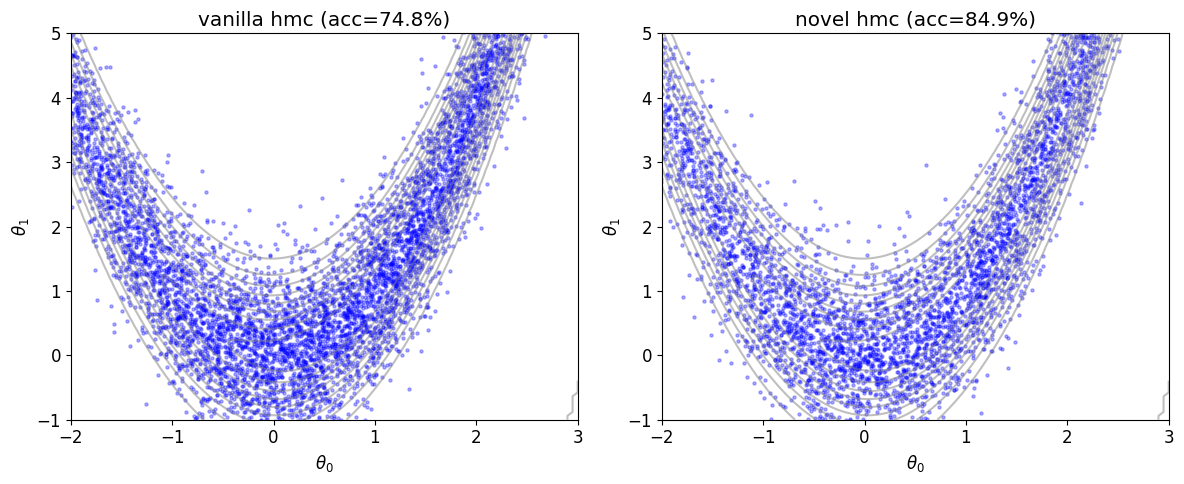

In [255]:
# TODO: Compare to baselines
# - Visualize samples (scatter plot with contours)
# - Compute ESS using samples_to_inference_data() and az.summary()
# - Plot traces and autocorrelation
# - Discuss: where does your method work well? Where does it struggle?

# This 'massages' the data, removing the first 10_000 samples as it could 
# this is fine as the first 10_000 can contribute to the noise as the 
# sampler figures out the best adaptive step_size
warmup = 10_000
clean_samples = novel_rosenbrock_samples[warmup:]

# Rosenbrock diagnostics
var_names = ["x", "y"]

hmc_rosenbrock_idata = samples_to_inference_data(hmc_samples, var_names)
novel_hmc_rosenbrock_idata = samples_to_inference_data(clean_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(hmc_samples, "Vanilla HMC — Rosenbrock", var_names)
summarize_sampler(clean_samples, "Novel HMC — Rosenbrock", var_names)

plot_samples_comparison(
    hmc_samples,
    clean_samples,
    f"vanilla hmc (acc={hmc_acc:.1%})",
    f"novel hmc (acc={novel_rosenbrock_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)


=== Vanilla HMC — Neals Funnel ===


,mean,sd,hdi_3%,hdi_97%
x,0.331,3.083,-5.926,5.481
y,-2.387,15.683,-13.667,13.108



=== Novel HMC — Neals Funnel ===


,mean,sd,hdi_3%,hdi_97%
x,0.518,2.554,-3.911,5.262
y,0.004,5.807,-9.284,8.267


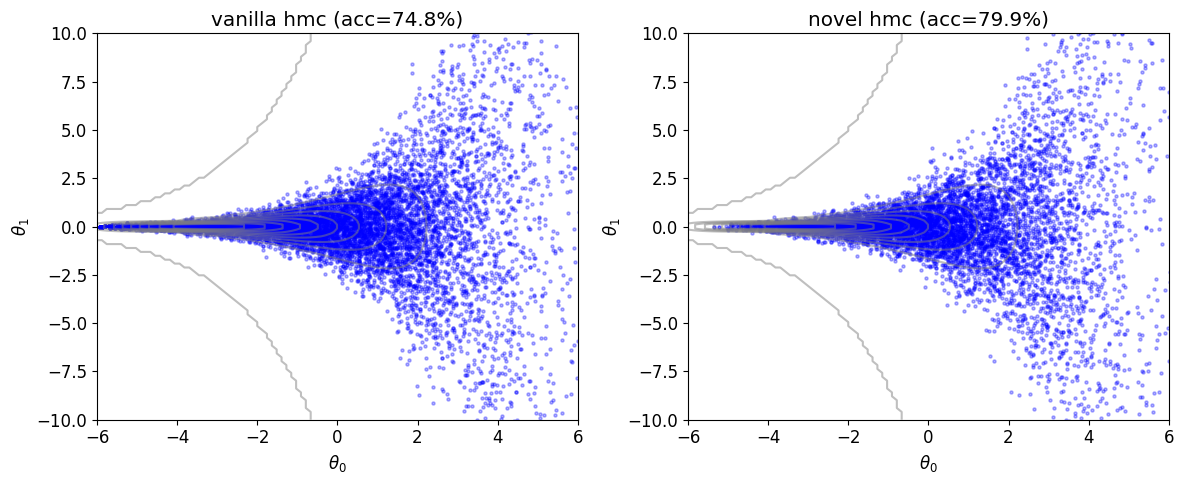

In [249]:
# This 'massages' the data, removing the first 10_000 samples as it could 
# this is fine as the first 10_000 can contribute to the noise as the 
# sampler figures out the best adaptive step_size
warmup = 10_000
clean_neal_samples = novel_neals_funnel_samples[warmup:]

# Rosenbrock diagnostics
var_names = ["x", "y"]

hmc_neals_idata = samples_to_inference_data(hmc_neals_samples, var_names)
novel_hmc_neals_idata = samples_to_inference_data(clean_neal_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(hmc_neals_samples, "Vanilla HMC — Neals Funnel", var_names)
summarize_sampler(clean_neal_samples, "Novel HMC — Neals Funnel", var_names)

plot_samples_comparison(
    hmc_neals_samples,
    clean_neal_samples,
    f"vanilla hmc (acc={hmc_acc:.1%})",
    f"novel hmc (acc={novel_neals_funnel_acc:.1%})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)

Vanilla HMC Trace Plots:


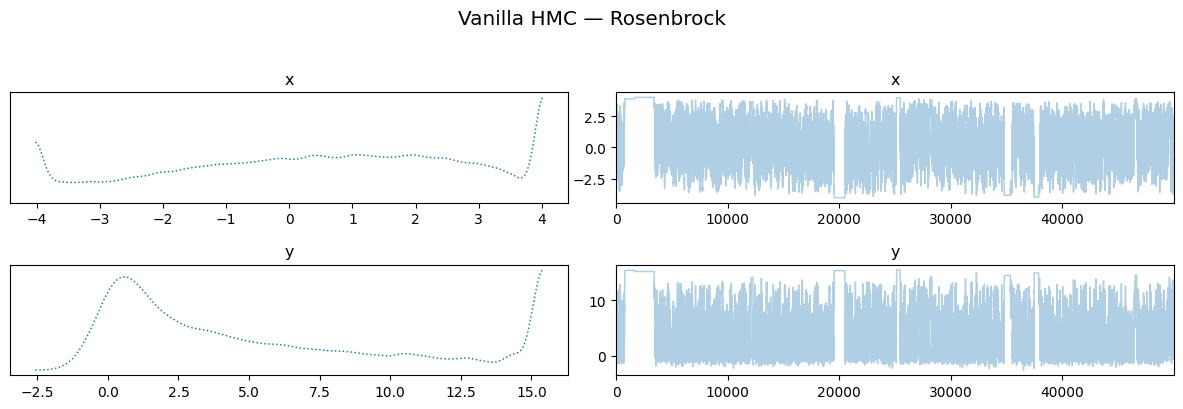


Novel HMC Trace Plots:


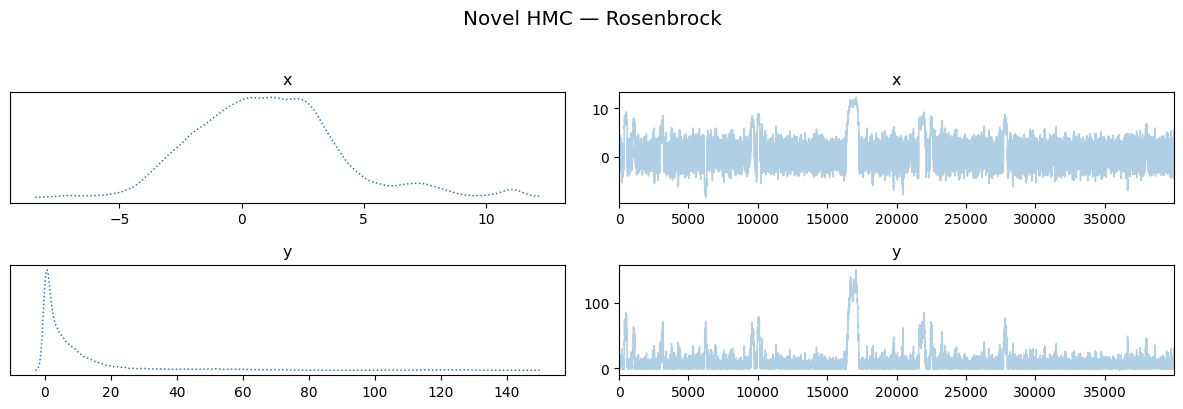

In [256]:
# Trace plots — Rosenbrock
print("Vanilla HMC Trace Plots:")
az.plot_trace(hmc_rosenbrock_idata, combined=True, figsize=(12, 4))
plt.suptitle("Vanilla HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nNovel HMC Trace Plots:")
az.plot_trace(novel_hmc_rosenbrock_idata, combined=True, figsize=(12, 4))
plt.suptitle("Novel HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

Vanilla HMC Trace Plots:


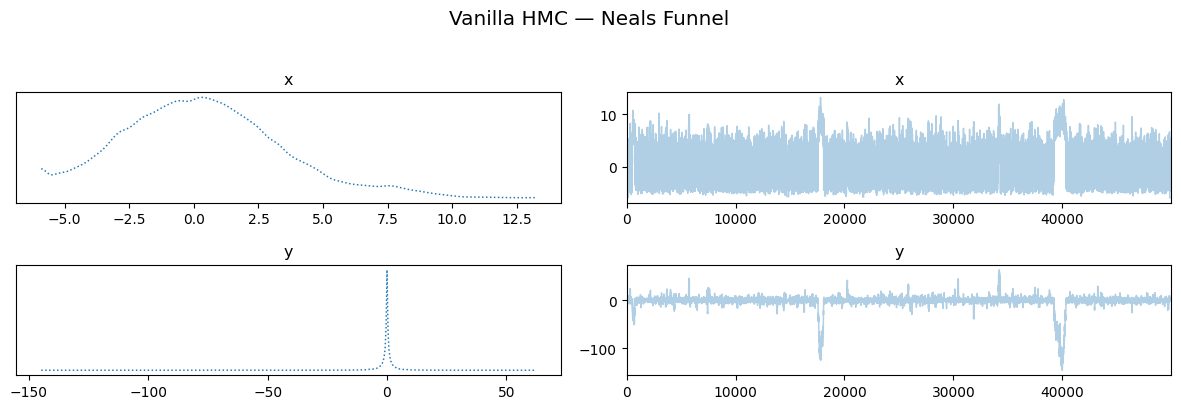


Novel HMC Trace Plots:


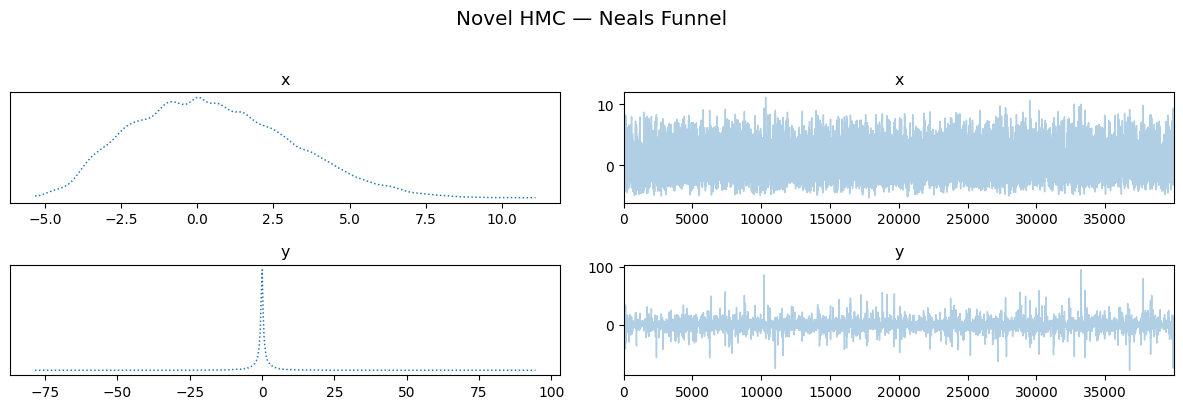

In [251]:
# Trace plots — Neals Funnel
print("Vanilla HMC Trace Plots:")
az.plot_trace(hmc_neals_idata, combined=True, figsize=(12, 4))
plt.suptitle("Vanilla HMC — Neals Funnel", y=1.02)
plt.tight_layout()
plt.show()

print("\nNovel HMC Trace Plots:")
az.plot_trace(novel_hmc_neals_idata, combined=True, figsize=(12, 4))
plt.suptitle("Novel HMC — Neals Funnel", y=1.02)
plt.tight_layout()
plt.show()